In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

from src.utils import reload_script

from models_src.Support import LRCallback
from models_src.fft_lib import xy_coords
from models_src.DETR import SinePositionEncoding, FFN, MHA
from models_src.window_queries import SinePositionEncodingFunc
from models_src.Attn_variations import SqueezeImg, UnSqueezeImg
from models_src.VecModels import VecLoss
from models_src.VecDataset import DatasetGenerator
import cv2 as cv

%matplotlib inline

print(tf.config.list_physical_devices('GPU'))

2024-08-08 14:54:40.207003: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 14:54:40.490433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-08 14:54:40.632572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-08 14:54:40.634077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-08 14:54:40.855299: I tensorflow/core/platform/cpu_feature_gua

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-08 14:54:51.673085: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:51.979812: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:51.979904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [59]:
reload_script('models_src.VecDataset')

# Angle encoding

## layers

In [37]:
def clock_radial_enc(angles, shifts_num, period=2):
    shifts = tf.reshape(tf.range(shifts_num, dtype=tf.float32), (1,1,1,shifts_num))

    encodings = tf.nn.relu(tf.cos(angles + period*shifts*math.pi/shifts_num))**(shifts_num//2)

    return encodings

def radial_dists(points, yx, size):
    return (tf.reduce_sum((yx[tf.newaxis]-points[:,tf.newaxis, tf.newaxis])**2, axis=-1, keepdims=True)**0.5)/(size*2**0.5)*math.pi

def frequency_encoding(r_embed, num_pos_features):
    dim_t = tf.range(num_pos_features//2, dtype=tf.float32)
    dim_freq = tf.reshape(tf.stack([dim_t]*2, axis=-1), (num_pos_features,))
    dim_ph = dim_freq/(num_pos_features//2)*math.pi*2

    pos_r = r_embed * dim_freq + dim_ph

    encodings = tf.concat([tf.math.sin(pos_r[...,0::2]),
                        tf.math.cos(pos_r[...,1::2])], axis=-1)
    
    return encodings

def add_batch_dims(x, batch_dims):
    return tf.reshape(x, tf.concat([tf.ones((batch_dims,), dtype=tf.int32), tf.shape(x)], axis=0))


class RadialEncoding(tf.keras.layers.Layer):
    def __init__(self, emb_dim, height, width=None, **kwargs):
        super().__init__(**kwargs)

        self.H = height
        self.W = height if width is None else width

        self.C = emb_dim

    def build(self, input_shape):

        batch_dims = len(input_shape)-1

        self.yx = add_batch_dims(xy_coords((self.H, self.W))[...,::-1], batch_dims)

        self.shifts_num = tf.constant(self.C//2, tf.float32)
        self.radial_period = tf.constant(2, tf.float32)
        self.ring_period = tf.constant(-1, tf.float32)

        self.shifts = add_batch_dims(tf.range(self.C//2, dtype=tf.float32), batch_dims+2)

        self.diag = tf.constant((self.H**2 + self.W**2)**0.5, tf.float32)

        self.radial_reg = tf.constant(self.C//4, tf.float32)

    def calc_angles(self, sample_points):
        return tf.math.atan2(*tf.split(self.yx-sample_points[...,tf.newaxis, tf.newaxis,:], 2, axis=-1))
    
    def clock_radial_enc(self, angles, period):
        return tf.nn.relu(tf.cos(angles + period*self.shifts*math.pi/self.shifts_num))**self.radial_reg
    
    def radial_dists(self, sample_points):
        return (tf.reduce_sum((self.yx-sample_points[...,tf.newaxis, tf.newaxis, :])**2, axis=-1, keepdims=True)**0.5)/self.diag*math.pi
    
    def freq_variables(self):
        dim_t = tf.range(self.radial_reg, dtype=tf.float32)
        dim_freq = tf.reshape(tf.stack([dim_t]*2, axis=-1), (self.shifts_num,))
        dim_ph = dim_freq/(self.radial_reg)*math.pi*2

        return dim_freq, dim_ph
    
    def frequency_encoding(self, r_embed):

        pos_r = r_embed * self.dim_freq + self.dim_ph

        encodings = tf.concat([tf.math.sin(pos_r[...,0::2]),
                            tf.math.cos(pos_r[...,1::2])], axis=-1)
        
        return encodings
    

class SeparateRadialEncoding(RadialEncoding):

    def call(self, sample_points):

        angles = self.calc_angles(sample_points)
        dists = self.radial_dists(sample_points)

        angle_encodings = self.clock_radial_enc(angles, self.radial_period)
        ring_encodings = self.clock_radial_enc(dists, self.ring_period)
        
        encodings = tf.concat([angle_encodings, ring_encodings], axis=-1)

        return encodings
    
class FrequencyRadialEncoding(RadialEncoding):

    def build(self, input_shape):
        super().build(input_shape)

        self.dim_freq, self.dim_ph = self.freq_variables()

    def call(self, sample_points):
        
        angles = self.calc_angles(sample_points)+math.pi
        dists = self.radial_dists(sample_points)*2

        angle_encodings = self.frequency_encoding(angles)
        ring_encodings = self.frequency_encoding(dists)

        encodings = tf.concat([angle_encodings, ring_encodings], axis=-1)

        return encodings

class ExtractSampleLayer(tf.keras.layers.Layer):
    def __init__(self, batch_dims=1, **kwargs):
        super().__init__(**kwargs)

        self.batch_dims = batch_dims

    def call(self, source, idxs):
        return tf.gather_nd(source, tf.cast(idxs, tf.int32), batch_dims=self.batch_dims)

class DetectionMHA(MHA):

    def call(self, V, Q, K, pos_enc, mask=None):
        Q = self.Q_head_extractior(self.Q_d(Q))
        K = self.K_head_extractior(self.K_d(K))

        scores = tf.matmul(Q, K, transpose_b=True)/self.denominator
        if mask is not None:
            if self.soft_mask:
                scores = scores + mask
            else:
                cross_mask = tf.expand_dims(tf.matmul(mask, mask, transpose_b=True), axis=1)
                scores = scores+((cross_mask-1)*math.inf)
        weights = self.softmax(scores, axis=self.softmax_axis)

        V = self.V_head_extractior(self.V_d(V))+pos_enc[:,tf.newaxis]
        if not self.T:
            V = tf.matmul(weights, V)
        else:
            V *= tf.transpose(weights, perm=[0,1,3,2])

        V = self.O_d(self.output_perm(V))

        if (mask is not None) & (self.soft_mask==False):
            return V*mask
        return V, weights
    
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super().__init__(**kwargs)

        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

## experiments

In [3]:
yx = xy_coords((32,32))[...,::-1]
print(yx.shape)

(32, 32, 2)


2024-08-08 11:53:20.898184: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


In [4]:
sample_points = tf.constant(np.random.randint(0,32, (8,2)), dtype=tf.float32)

angles = tf.math.atan2(*tf.split(yx[tf.newaxis]-sample_points[:,tf.newaxis, tf.newaxis], 2, axis=-1))
print(angles.shape)

(8, 32, 32, 1)


## default sine encoding

In [115]:
size = 32
embs_size = 64
encodings = SinePositionEncodingFunc(dim=32, embs_size=embs_size, temperature=1e1)
encodings = tf.reshape(encodings, (size,size,embs_size))
print(encodings.shape)

(32, 32, 64)


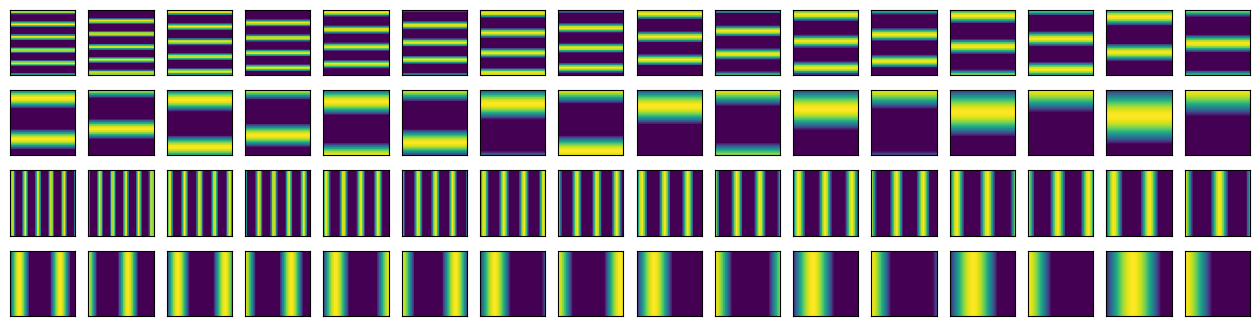

In [116]:
fig, axs = plt.subplots(4,16, figsize=(1*16, 1*4))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[...,i], vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

enc sum range:  31.017735
enc max range:  0.02439481


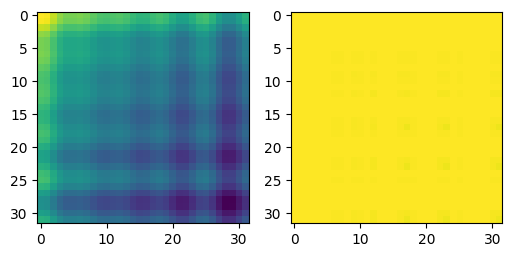

In [12]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings, axis=-1)
enc_max = tf.reduce_max(encodings, axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Radial enc

### separate radial enc

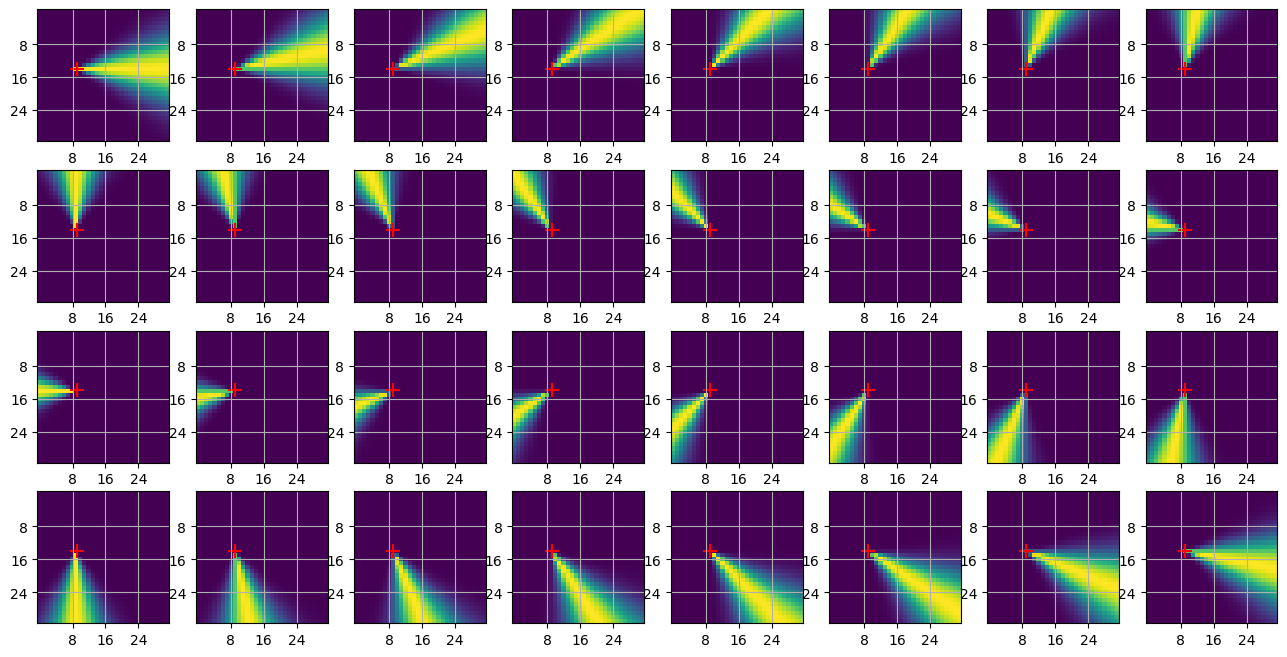

In [216]:
shifts_num = 32
encodings = clock_radial_enc(angles, shifts_num=shifts_num, period=2)

n = 0
cols = 8
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  4.2915344e-06
enc max range:  0.07299298


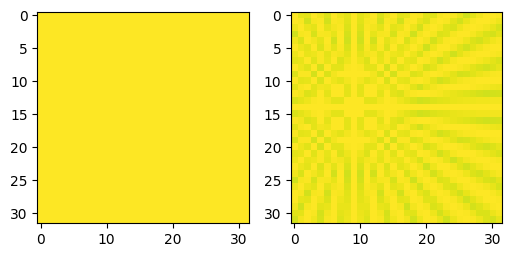

In [217]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n], axis=-1)
enc_max = tf.reduce_max(encodings[n], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency radial enc

In [268]:
num_pos_features = 32
encodings = frequency_encoding(angles+math.pi, num_pos_features=num_pos_features)
encodings = tf.reshape(tf.transpose(tf.reshape(encodings, (8,32,32,2,num_pos_features//2)), perm=[0,1,2,4,3]), (8,32,32,num_pos_features))

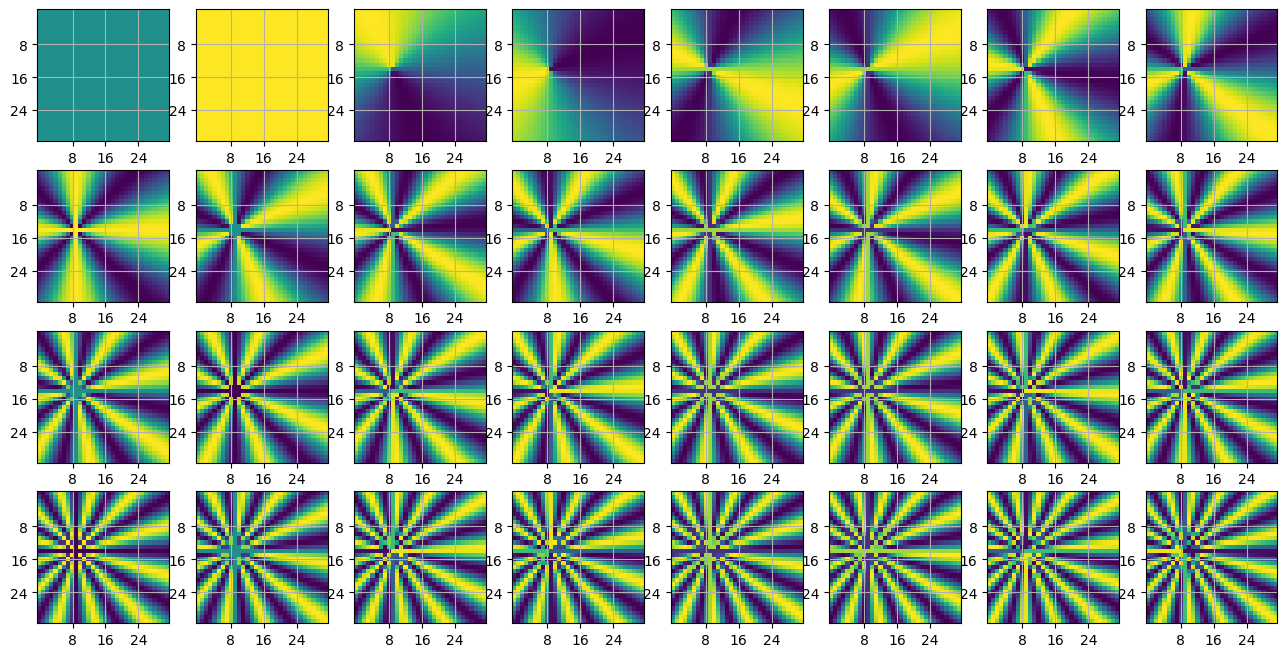

In [269]:
n=0
cols = 8
rows = num_pos_features//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=-1, vmax=1)
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  30.364939
enc max range:  0.039666474


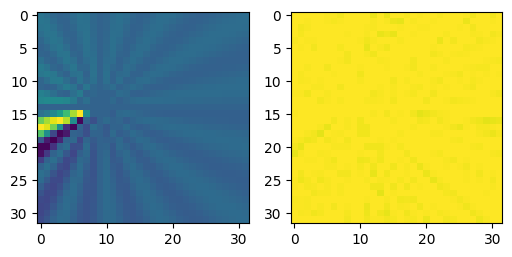

In [270]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Distance encoding

### separate ring enc

In [237]:
shifts_num = 32
size = 32

print(yx.shape, sample_points.shape)
dists = radial_dists(sample_points, yx, size)
print(dists.shape)

(32, 32, 2) (8, 2)
(8, 32, 32, 1)


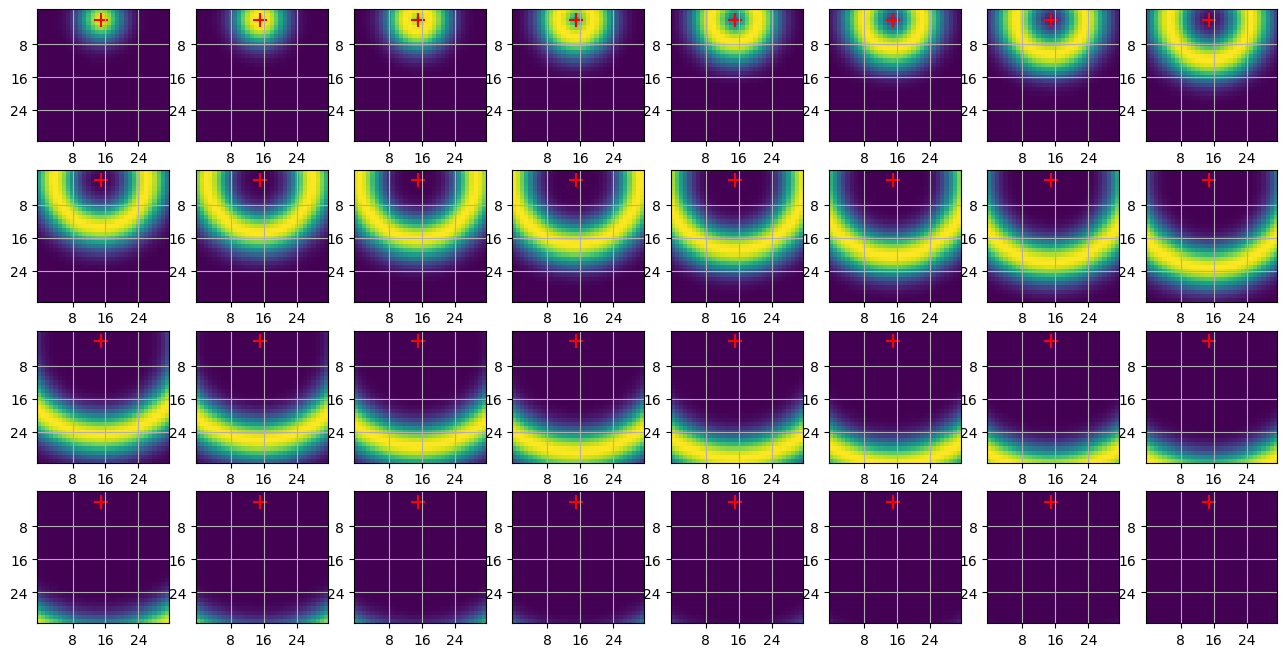

In [238]:
encodings = clock_radial_enc(dists, shifts_num, period=-1)

n = 1
cols = 8
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  2.6420913
enc max range:  0.018662214


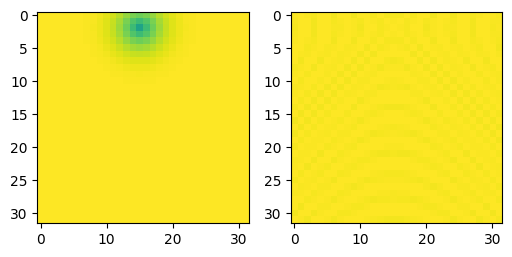

In [221]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n], axis=-1)
enc_max = tf.reduce_max(encodings[n], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency ring enc

In [248]:
size = 32
num_pos_features = 32
r_embed = radial_dists(sample_points, yx, size)*2

encodings = frequency_encoding(r_embed, num_pos_features=num_pos_features)
encodings = tf.reshape(tf.transpose(tf.reshape(encodings, (8,32,32,2,num_pos_features//2)), perm=[0,1,2,4,3]), (8,32,32,num_pos_features))

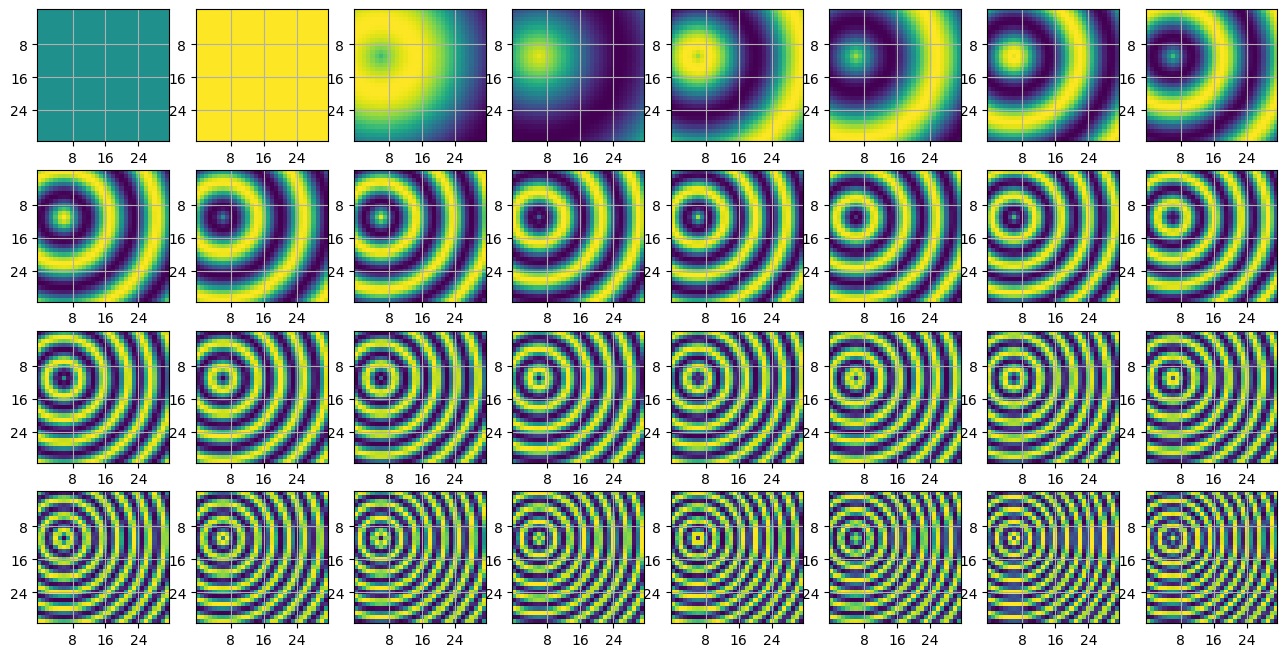

In [249]:
n=3
cols = 8
rows = num_pos_features//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=-1, vmax=1)
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  5.8787293
enc max range:  0.040088415


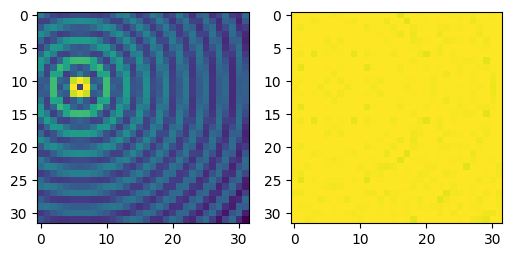

In [250]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Mixed encodings

### separate

In [47]:
shifts_num = 32
size = 32

dists = radial_dists(sample_points, yx, size)

ring_encodings = clock_radial_enc(dists, shifts_num, period=-1)
angle_encodings = clock_radial_enc(angles, shifts_num=shifts_num, period=2)

encodings = tf.concat([ring_encodings, angle_encodings], axis=-1)

In [62]:
encodings = SeparateRadialEncoding(emb_dim=64, height=32)(sample_points)
print(encodings.shape)

(8, 32, 32, 64)


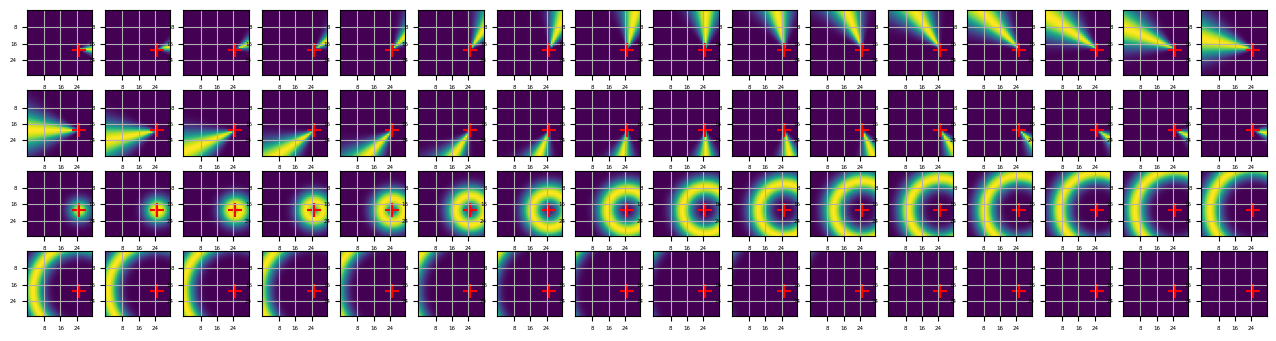

In [63]:
n = 1
shifts_num = encodings.shape[-1]
cols = 16
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(1*cols, 1*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='major', labelsize=4)
    ax.grid()

enc sum range:  2.6420937
enc max range:  0.01859194


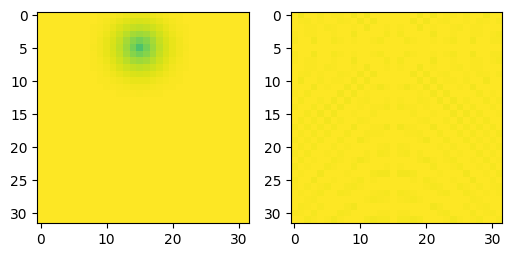

In [55]:
n=0
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,0:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,0:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency

In [251]:
size = 32
num_pos_features = 32
r_embed = radial_dists(sample_points, yx, size)*2

ring_encodings = frequency_encoding(r_embed, num_pos_features=num_pos_features)
angle_encodings = frequency_encoding(angles+math.pi, num_pos_features=num_pos_features)

encodings = tf.concat([ring_encodings, angle_encodings], axis=-1)

In [64]:
encodings = FrequencyRadialEncoding(emb_dim=64, height=32)(sample_points)
print(encodings.shape)

(8, 32, 32, 64)


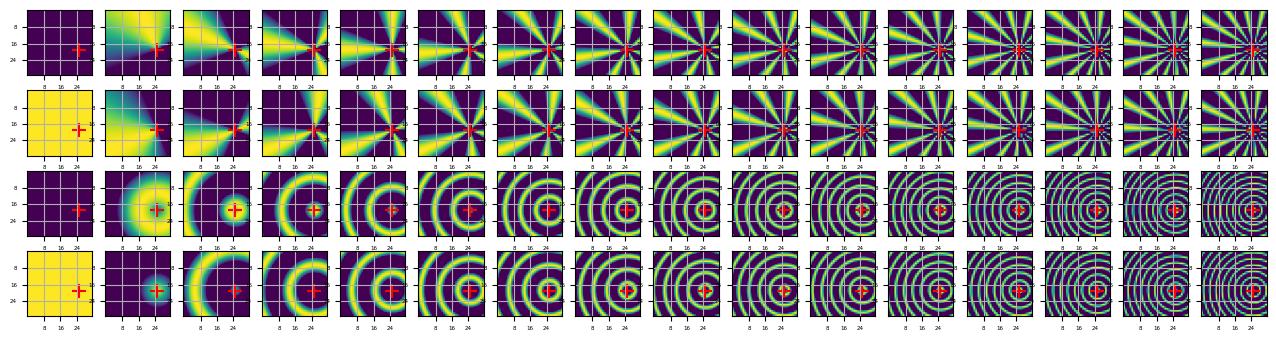

In [65]:
n = 1
shifts_num = encodings.shape[-1]
cols = 16
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(1*cols, 1*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='major', labelsize=4)
    ax.grid()

enc sum range:  31.683395
enc max range:  0.0


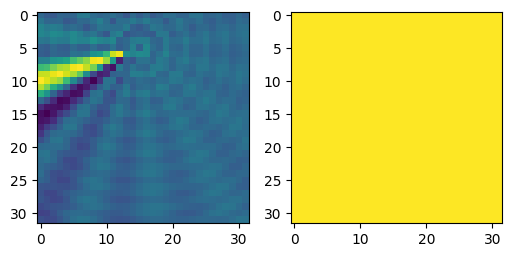

In [66]:
n=0
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

# Validation

## Dataset

In [3]:
class SimpleLineMapGenerator():
    def __init__(self, size, thickness_range, randomize_range):

        self.size = size
        self.thickness_min, self.thickness_max = thickness_range
        self.randomize_range = randomize_range

        self.output_dtypes = [tf.float32, tf.int32, tf.int32]
        self.output_shapes = self.output_padded_shapes = [(size, size, 3), (2,), (2,2)]
        self.output_savenames = ['Aimg', 'Bsample_point', 'Clabel']

        self.outputs = ['img', 'sample_point', 'label']

    def draw_random_line(self):

        img = np.zeros((self.size, self.size, 1), dtype=np.uint8)
        startpoint, endpoint = np.random.randint(0, self.size, (2,2))
        thickness = np.random.randint(self.thickness_min, self.thickness_max)

        img = cv.line(img, startpoint, endpoint, color=1, thickness=thickness)

        coords = np.stack(np.where(img>0)[:2], axis=-1)
        idx = np.random.randint(0, len(coords))
        sample_point = coords[idx]

        vec = np.stack([startpoint, endpoint], axis=0)[...,::-1]

        return img.astype(np.float32), sample_point.astype(np.int32), vec.astype(np.int32)

    def random_colors(self):
        randomize_shifts = np.random.uniform(-self.randomize_range, self.randomize_range, (self.size, self.size, 3))
        background_colors = np.random.uniform(0,1, (1, 1, 3))+randomize_shifts
        line_colors = np.random.uniform(0,1, (1,1,3))+randomize_shifts

        return tf.clip_by_value(background_colors.astype(np.float32), 0,1), tf.clip_by_value(line_colors.astype(np.float32), 0, 1)

    @tf.function
    def tf_random_line_img(self):
        line_mask, sample_point, label = tf.py_function(self.draw_random_line, [], Tout=[tf.float32, tf.int32, tf.int32])
        background_colors, line_colors = tf.py_function(self.random_colors, [], Tout=[tf.float32, tf.float32])

        img = background_colors*(1-line_mask) + line_colors*line_mask

        img.set_shape((self.size, self.size, 3))
        sample_point.set_shape((2,))
        label.set_shape((2,2))

        return img, tf.cast(sample_point, tf.int32), tf.cast(label, tf.int32)
    
    def __call__(self):
        return self.tf_random_line_img()
    
def output_formatter(img, sample_point, label):
    return (img, tf.cast(sample_point, tf.float32)), tf.cast(label, tf.float32)

In [4]:
slmg = SimpleLineMapGenerator(size=32, thickness_range=(1,3), randomize_range=0.1)

In [5]:
dg = DatasetGenerator(slmg, 
                      ds_path='./datasets/pos_enc_test', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=False, 
                      output_filter=None,
                      preprocess_funcs=[(output_formatter, {}, True)],
                      set_shapes=True
                      )


In [38]:
#dg.save_tfrec_dataset(folds_num=9, starting_num=0)


saving fold 1/9
   7/2048 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step  

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step

saving fold 2/9
  14/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step 

2024-08-08 13:35:33.014113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step

saving fold 3/9
  14/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step

2024-08-08 13:35:51.566013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step

saving fold 4/9
  14/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step

2024-08-08 13:36:08.358202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step

saving fold 5/9
  15/2048 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step

2024-08-08 13:36:24.483926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step


2024-08-08 13:36:42.421315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



saving fold 6/9
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step

saving fold 7/9
  12/2048 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step

2024-08-08 13:37:02.742608: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step

saving fold 8/9
  16/2048 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step

2024-08-08 13:37:18.530995: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step

saving fold 9/9
  14/2048 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step

2024-08-08 13:37:33.842747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step


2024-08-08 13:37:51.057081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
ds, train_steps = dg.dataset(from_saved=True, batch_size=32, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=256, validation=True, val_idxs=[0], shuffle_buffer_size=128)
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=8, validation=True, val_idxs=[0], shuffle_buffer_size=128)
ds_iter = iter(ds)
test_iter = iter(test_ds)

2024-08-08 14:54:53.655795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:53.656165: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:53.656214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:54.039890: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-08 14:54:54.040002: I external/local_xla/xla/stream_executor

(32, 32, 32, 3) (32, 2) (32, 2, 2)


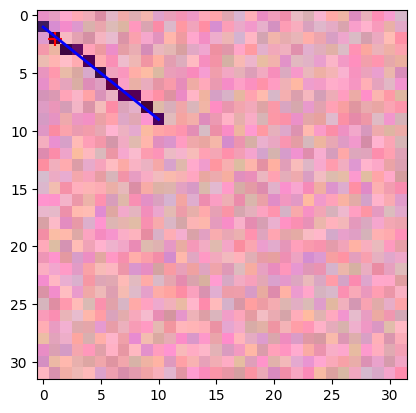

In [82]:
features, vec = next(ds_iter)
img, sample_point = features
print(img.shape, sample_point.shape, vec.shape)

plt.imshow(img[0])
plt.plot(*np.transpose(vec[0], axes=[1,0])[::-1], color='blue', linewidth=2)
plt.scatter(*sample_point[0,::-1], marker='+', color='red', s=100)

# Models

In [20]:
model_args = {
    'size': 32,
    'color_embs': 16,
    'conv_layers': 3,
    'kernel_size': 3,
    'embs_dim': 64,
    'mid_layers': 3,
    'out_mid_layers': 3,
    'out_units': 32,
    'corection_mid_layers': 2,
    'corection_units': 32,
    'num_heads': 2,
    'activation': 'relu',
    'temperature': 1e1
}

## default sine encoding

In [38]:
def gen_sine_enc_model(size, color_embs, conv_layers, kernel_size, embs_dim, mid_layers, out_mid_layers, out_units, corection_mid_layers, corection_units, num_heads, activation, dropout, temperature, **kwargs):
    img_inputs = tf.keras.layers.Input((size, size,3))
    sample_inputs = tf.keras.layers.Input((2,))

    features = tf.keras.layers.BatchNormalization()(img_inputs)
    color_features = FFN(mid_layers=mid_layers, mid_units=color_embs*2, output_units=color_embs, dropout=dropout, activation=activation)(features)

    conv_units = embs_dim-color_embs
    for _ in range(conv_layers):
        features = tf.keras.layers.Conv2D(conv_units, kernel_size=kernel_size, padding='same', activation=activation)(features)

    features = tf.keras.layers.Concatenate()([features, color_features])

    pos_enc = SinePositionEncoding(temperature=temperature)(features[...,0::2])
    pos_enc = ExpandDimsLayer(axis=0)(pos_enc)

    sample_features = ExtractSampleLayer(batch_dims=1)(features, sample_inputs)
    sample_features = tf.keras.layers.Reshape((1, embs_dim))(sample_features)
    features = SqueezeImg()(features)

    x, _ = DetectionMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads)(features, sample_features, features, pos_enc)
    x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=out_units, dropout=dropout, activation=activation)(x)
    x = tf.keras.layers.Reshape((out_units,))(x)
    x = tf.keras.layers.Concatenate(axis=-1)([x, sample_inputs])
    x = FFN(mid_layers=corection_mid_layers, mid_units=corection_units, output_units=4, activation=activation)(x)
    x = tf.keras.layers.Reshape((2,2))(x)

    return tf.keras.Model((img_inputs, sample_inputs), x)

In [39]:
sine_model = gen_sine_enc_model(**model_args, dropout=0.2)
sine_model.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_38[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_33[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_34[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_16 (FFN)        │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 32, 32,    │          0 │ conv2d_35[0][0],  │
│ (Concatenate)       │ 64)               │            │ ffn_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_39      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 32, 32,    │          0 │ concatenate_11[0… │
│ (GetItem)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_11[0… │
│ (ExtractSampleLaye… │                   │            │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (1024, 32)        │          0 │ get_item_7[0][0]  │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_12      │ (None, 1024, 64)  │          0 │ concatenate_11[0… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_32          │ (None, 1, 64)     │          0 │ extract_sample_l… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_layer   │ (1, 1024, 32)     │          0 │ sine_position_en… │
│ (ExpandDimsLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection_mha_2     │ [(None, 1, 64),   │     16,640 │ squeeze_img_12[0… │
│ (DetectionMHA)      │ (None, 2, 1,      │            │ reshape_32[0][0], │
│                     │ 1024)]            │            │ squeeze_img_12[0… │
│                     │                   │            │ expand_dims_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_17 (FFN)        │ (None, 1, 32)     │     45,472 │ detection_mha_2[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 110,112 (430.12 KB)

 Trainable params: 110,106 (430.10 KB)

 Non-trainable params: 6 (24.00 B)

In [40]:
sine_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [41]:
sine_history = sine_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20


511/512 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 13.2680

I0000 00:00:1723122566.429473  141497 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 372 bytes spill stores, 372 bytes spill loads

I0000 00:00:1723122566.621259  141499 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 360 bytes spill stores, 360 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - loss: 13.2576 - val_loss: 9.4075 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 9.2891 - val_loss: 8.3040 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.8170 - val_loss: 7.1427 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.8557 - val_loss: 5.9680 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 5.8572 - val_loss: 4.7533 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.6934 - val_loss: 3.6506 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.8784 - val_loss: 3.1579 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.3641 - val_loss: 2.7168 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.0474 - val_loss: 2.5494 - learnin

## radial encoding

In [45]:
def gen_radial_enc_model(size, color_embs, conv_layers, kernel_size, embs_dim, mid_layers, out_mid_layers, out_units, corection_mid_layers, corection_units, num_heads, activation, dropout, temperature, enc_type, **kwargs):
    img_inputs = tf.keras.layers.Input((size, size,3))
    sample_inputs = tf.keras.layers.Input((2,))

    features = tf.keras.layers.BatchNormalization()(img_inputs)
    color_features = FFN(mid_layers=mid_layers, mid_units=color_embs*2, output_units=color_embs, dropout=dropout, activation=activation)(features)

    conv_units = embs_dim-color_embs
    for _ in range(conv_layers):
        features = tf.keras.layers.Conv2D(conv_units, kernel_size=kernel_size, padding='same', activation=activation)(features)

    features = tf.keras.layers.Concatenate()([features, color_features])

    if enc_type=='separate':
        pos_enc = SeparateRadialEncoding(emb_dim=embs_dim//num_heads, height=size)(sample_inputs)
    else:
        pos_enc = FrequencyRadialEncoding(emb_dim=embs_dim//num_heads, height=size)(sample_inputs)

    sample_features = ExtractSampleLayer(batch_dims=1)(features, sample_inputs)
    sample_features = tf.keras.layers.Reshape((1, embs_dim))(sample_features)
    features = SqueezeImg()(features)
    pos_enc = SqueezeImg()(pos_enc)

    x, _ = DetectionMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name='MHA')(features, sample_features, features, pos_enc)
    x = tf.keras.layers.Add()([sample_features, x])
    x = tf.keras.layers.LayerNormalization(axis=-1)(x)
    x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=4, dropout=dropout, activation=activation)(x)
    x = tf.keras.layers.Reshape((2,2))(x)

    sample_coords = tf.keras.layers.Reshape((1,2))(sample_inputs)
    x = tf.keras.layers.Add()([x, sample_coords])

    return tf.keras.Model((img_inputs, sample_inputs), x)

### separate encoding

In [46]:
sep_model = gen_radial_enc_model(**model_args, enc_type='separate', dropout=0.0)
sep_model.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_47      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_47[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_39[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_40[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_21 (FFN)        │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 32, 32,    │          0 │ conv2d_41[0][0],  │
│ (Concatenate)       │ 64)               │            │ ffn_21[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_48      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_14[0… │
│ (ExtractSampleLaye… │                   │            │ input_layer_48[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separate_radial_en… │ (None, 32, 32,    │          0 │ input_layer_48[0… │
│ (SeparateRadialEnc… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_41          │ (None, 1, 64)     │          0 │ extract_sample_l… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_15      │ (None, 1024, 64)  │          0 │ concatenate_14[0… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_16      │ (None, 1024, 32)  │          0 │ separate_radial_… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MHA (DetectionMHA)  │ [(None, 1, 64),   │     16,640 │ squeeze_img_15[0… │
│                     │ (None, 2, 1,      │            │ reshape_41[0][0], │
│                     │ 1024)]            │            │ squeeze_img_15[0… │
│                     │                   │            │ squeeze_img_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 1, 64)     │          0 │ reshape_41[0][0], │
│                     │                   │            │ MHA[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_12[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 104,320 (407.50 KB)

 Trainable params: 104,314 (407.48 KB)

 Non-trainable params: 6 (24.00 B)

In [47]:
sep_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [48]:
sep_history = sep_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20


512/512 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 8.6167 - val_loss: 3.6857 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.1832 - val_loss: 1.9851 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.9939 - val_loss: 1.6515 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.5709 - val_loss: 1.6298 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.3222 - val_loss: 1.3269 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2403 - val_loss: 1.1277 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.1391 - val_loss: 1.1163 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.0689 - val_loss: 1.2158 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.1041 - val_loss: 0.9604 - learning_rate

### freq encoding

In [42]:
freq_model = gen_radial_enc_model(**model_args, enc_type='frequency', dropout=0.0)
freq_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_43      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_43[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_36[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_37[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_19 (FFN)        │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 32, 32,    │          0 │ conv2d_38[0][0],  │
│ (Concatenate)       │ 64)               │            │ ffn_19[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_44      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_13[0… │
│ (ExtractSampleLaye… │                   │            │ input_layer_44[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency_radial_e… │ (None, 32, 32,    │          0 │ input_layer_44[0… │
│ (FrequencyRadialEn… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_36          │ (None, 1, 64)     │          0 │ extract_sample_l… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_13      │ (None, 1024, 64)  │          0 │ concatenate_13[0… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_14      │ (None, 1024, 32)  │          0 │ frequency_radial… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MHA (DetectionMHA)  │ [(None, 1, 64),   │     16,640 │ squeeze_img_13[0… │
│                     │ (None, 2, 1,      │            │ reshape_36[0][0], │
│                     │ 1024)]            │            │ squeeze_img_13[0… │
│                     │                   │            │ squeeze_img_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 1, 64)     │          0 │ reshape_36[0][0], │
│                     │                   │            │ MHA[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 104,320 (407.50 KB)

 Trainable params: 104,314 (407.48 KB)

 Non-trainable params: 6 (24.00 B)

In [43]:
freq_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [44]:
freq_history = freq_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 8.1420 - val_loss: 3.1822 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.9210 - val_loss: 2.0325 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.9521 - val_loss: 1.8820 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.7317 - val_loss: 1.5081 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.5207 - val_loss: 1.4707 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.3527 - val_loss: 1.3126 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2638 - val_loss: 1.2678 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.2094 - val_loss: 1.3614 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.1836 - val_loss: 1.1459 - l

In [49]:
mha_output_model = tf.keras.Model(freq_model.inputs, freq_model.get_layer('MHA').output)

(32, 2, 1, 1024)


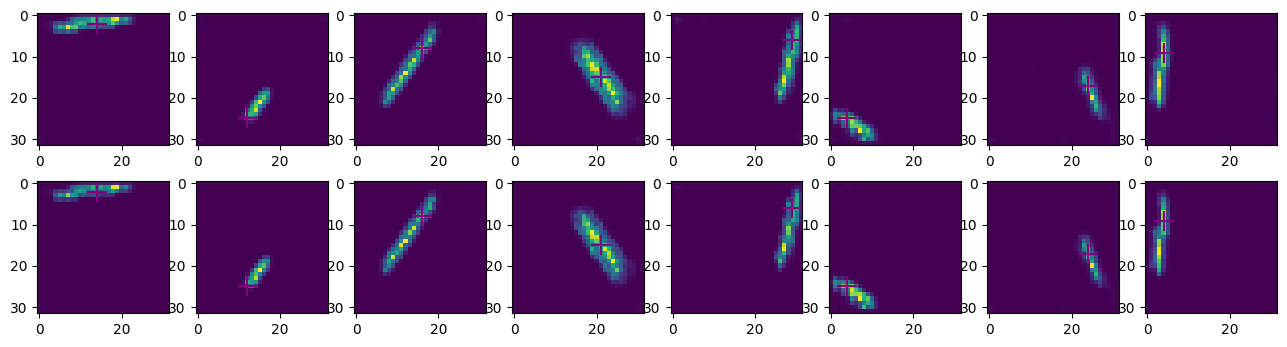

In [52]:
features, label_vec = next(ds_iter)
img, sample_point = features

x, scores = mha_output_model([img, sample_point])
print(scores.shape)
heads_num = scores.shape[1]
scores = tf.reshape(scores, (-1, heads_num, 32, 32))

s=8

fig, axs = plt.subplots(heads_num, 8, figsize=(8*2, heads_num*2))

for i in range(s):
    for j in range(heads_num):
        axs[j,i].imshow(scores[i,j])
        axs[j,i].scatter(*sample_point[i,::-1], marker='+', color='purple', s=200)

## test

sine loss:  1.633
separate loss:  0.749
frequency loss:  0.885


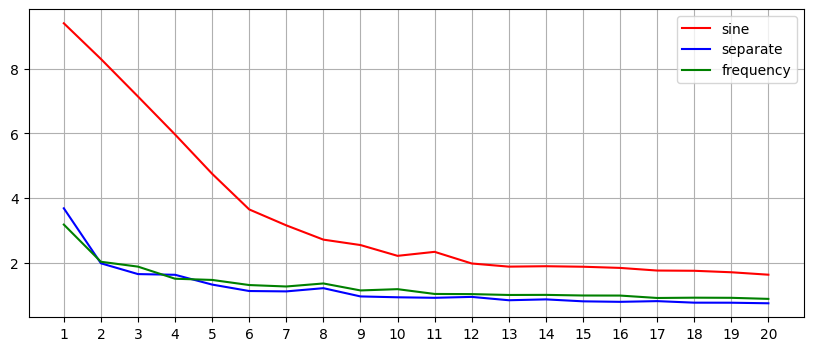

In [51]:
colors = ['red', 'blue', 'green']
plot_labels = ['sine', 'separate', 'frequency']
val_losses = [h.history['val_loss'] for h in [sine_history, sep_history, freq_history]]


plt.figure(figsize=(10,4))

x = list(range(1,21))
for h, clr, lbl in zip(val_losses, colors, plot_labels):
    print(f'{lbl} loss: ', np.round(h[-1], 3))
    plt.plot(x, h, color=clr, label=lbl)

plt.legend()
plt.xticks(x)
plt.grid()
plt.show()

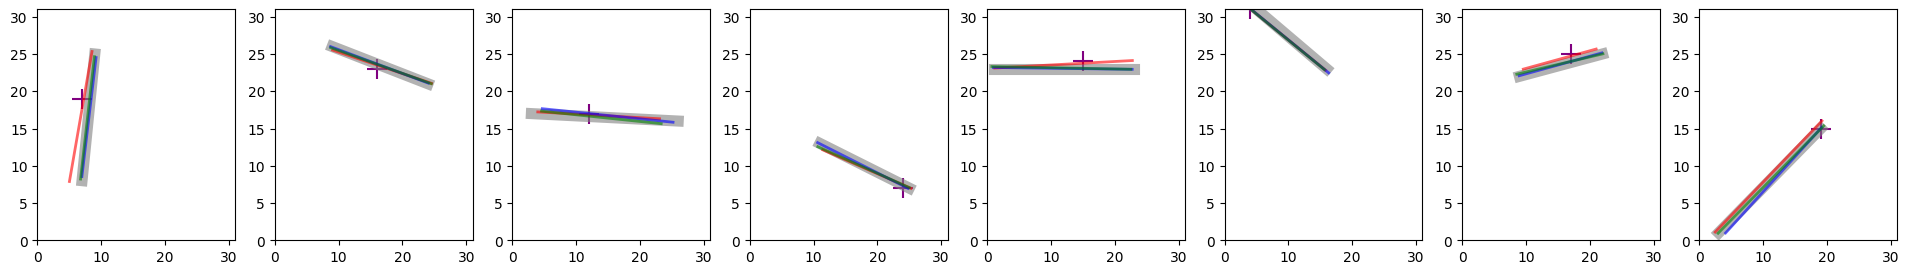

In [53]:
features, label_vec = next(ds_iter)
img, sample_point = features

sine_vec, sep_vec, freq_vec = [m([img, sample_point], training=False) for m in [sine_model, sep_model, freq_model]]

s=8

fig, axs = plt.subplots(1, s, figsize=(3*s, 3))

colors = ['gray', 'red', 'blue', 'green']
line_widths = [8,2,2,2]

for i, ax in enumerate(axs):
    for clr, vec, lw in zip(colors, [v[i] for v in [label_vec, sine_vec, sep_vec, freq_vec]], line_widths):
        ax.plot(*np.transpose(vec, axes=[1,0])[::-1], color=clr, linewidth=lw, alpha=0.6)

    ax.scatter(*sample_point[i,::-1], marker='+', color='purple', s=200)

    ax.set_xlim(0,31)
    ax.set_ylim(0,31)